# Inspecting and Comparing Embeddings

### Imports and Data Loading

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

# Load all four embedding sources

# Load PyTorch embeddings
with open('word2vec_embeddings.pkl', 'rb') as f:
    pytorch_data = pickle.load(f)
    pytorch_embeddings = pytorch_data['embeddings']
    pytorch_word2idx = pytorch_data['word2idx']

# Load Gensim embeddings
with open('word2vec_gensim_embeddings.pkl', 'rb') as f:
    gensim_data = pickle.load(f)
    gensim_embeddings = gensim_data['embeddings']
    gensim_word2idx = gensim_data['word2idx']

# Load Pretrained Word2Vec (Google News)
import gensim.downloader as api
googlenews_model = api.load('word2vec-google-news-300')

# Load Pretrained FastText
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

print(f"PyTorch: {pytorch_embeddings.shape}")
print(f"Gensim: {gensim_embeddings.shape}")
print(f"Google News: 300-dim pretrained")
print(f"FastText: 300-dim pretrained")

[nltk_data] Downloading package punkt to /Users/junhohong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/junhohong/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


PyTorch: (18497, 100)
Gensim: (18497, 100)
Google News: 300-dim pretrained
FastText: 300-dim pretrained


### Sentence Similarity

In [2]:
# Tokenization function
def tokenize_text(text):
    return word_tokenize(text.lower())

# Helper function to get sentence embedding by averaging word embeddings
def get_sentence_embedding(sentence, embeddings, word2idx):
    """
    Compute sentence embedding as the average of word embeddings.
    
    Args:
        sentence: string to embed
        embeddings: numpy array of word vectors [vocab_size, embedding_dim]
        word2idx: dictionary mapping words to indices
    
    Returns:
        sentence_vector: average embedding of all words in sentence
    """
    tokens = tokenize_text(sentence)
    word_vectors = []
    
    for token in tokens:
        if token in word2idx:
            idx = word2idx[token]
            word_vectors.append(embeddings[idx])
    
    if len(word_vectors) == 0:
        # Return zero vector if no words found
        return np.zeros(embeddings.shape[1])
    
    # Return mean of all word vectors
    return np.mean(word_vectors, axis=0)

# For pretrained models (Gensim API)
def get_sentence_embedding_pretrained(sentence, model):
    """
    Compute sentence embedding using pretrained Gensim model.
    
    Args:
        sentence: string to embed
        model: Gensim KeyedVectors model
    
    Returns:
        sentence_vector: average embedding
    """
    tokens = tokenize_text(sentence)
    word_vectors = []
    
    for token in tokens:
        if token in model:
            word_vectors.append(model[token])
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    
    return np.mean(word_vectors, axis=0)

# List of sentences for comparison
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."

print(f"\nQuery: '{query}'\n")

# Function to compute and display similarities
def compute_similarities(query, sentences, embeddings, word2idx, model_name, is_pretrained=False, model=None):
    """
    Compute cosine similarities between query and all sentences.
    """
    print(f"\n{model_name}:")
    print("-" * 60)
    
    # Get query embedding
    if is_pretrained:
        query_vec = get_sentence_embedding_pretrained(query, model)
    else:
        query_vec = get_sentence_embedding(query, embeddings, word2idx)
    
    # Compute similarities for each sentence
    for i, sent in enumerate(sentences, 1):
        if is_pretrained:
            sent_vec = get_sentence_embedding_pretrained(sent, model)
        else:
            sent_vec = get_sentence_embedding(sent, embeddings, word2idx)
        
        # Compute cosine similarity
        similarity = cosine_similarity([query_vec], [sent_vec])[0][0]
        
        print(f"{i}. [{similarity:.4f}] {sent}")

# Compare across all four embedding sources
compute_similarities(query, sentences, pytorch_embeddings, pytorch_word2idx, 
                    "PyTorch Skip-Gram (100d)")

compute_similarities(query, sentences, gensim_embeddings, gensim_word2idx, 
                    "Gensim Word2Vec (100d)")

compute_similarities(query, sentences, None, None, 
                    "Word2Vec Google News (300d)", 
                    is_pretrained=True, model=googlenews_model)

compute_similarities(query, sentences, None, None, 
                    "FastText (300d)", 
                    is_pretrained=True, model=fasttext_model)


Query: 'My pet cat is sleeping on the carpet.'


PyTorch Skip-Gram (100d):
------------------------------------------------------------
1. [0.7178] The cat sat on the mat.
2. [0.6712] A dog is playing in the yard.
3. [0.5548] I need to buy groceries today.
4. [0.5956] The feline was resting on the rug.
5. [0.3857] Canines enjoy outdoor activities.
6. [0.6253] My shopping list includes milk and bread.
7. [0.5818] The weather is beautiful today.
8. [0.2856] Programming requires logical thinking.

Gensim Word2Vec (100d):
------------------------------------------------------------
1. [0.6863] The cat sat on the mat.
2. [0.5800] A dog is playing in the yard.
3. [0.1865] I need to buy groceries today.
4. [0.4823] The feline was resting on the rug.
5. [0.0432] Canines enjoy outdoor activities.
6. [0.4683] My shopping list includes milk and bread.
7. [0.4769] The weather is beautiful today.
8. [0.0738] Programming requires logical thinking.

Word2Vec Google News (300d):
---------------------

### Embedding Visualization

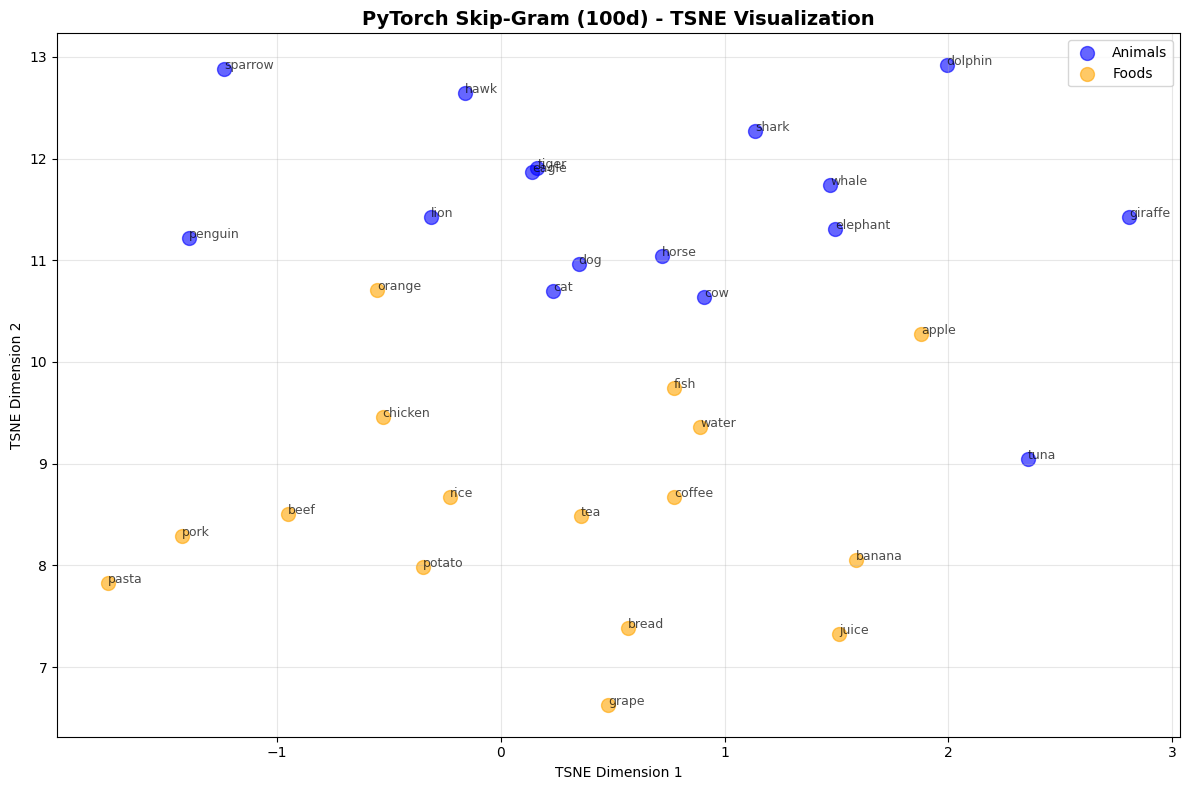

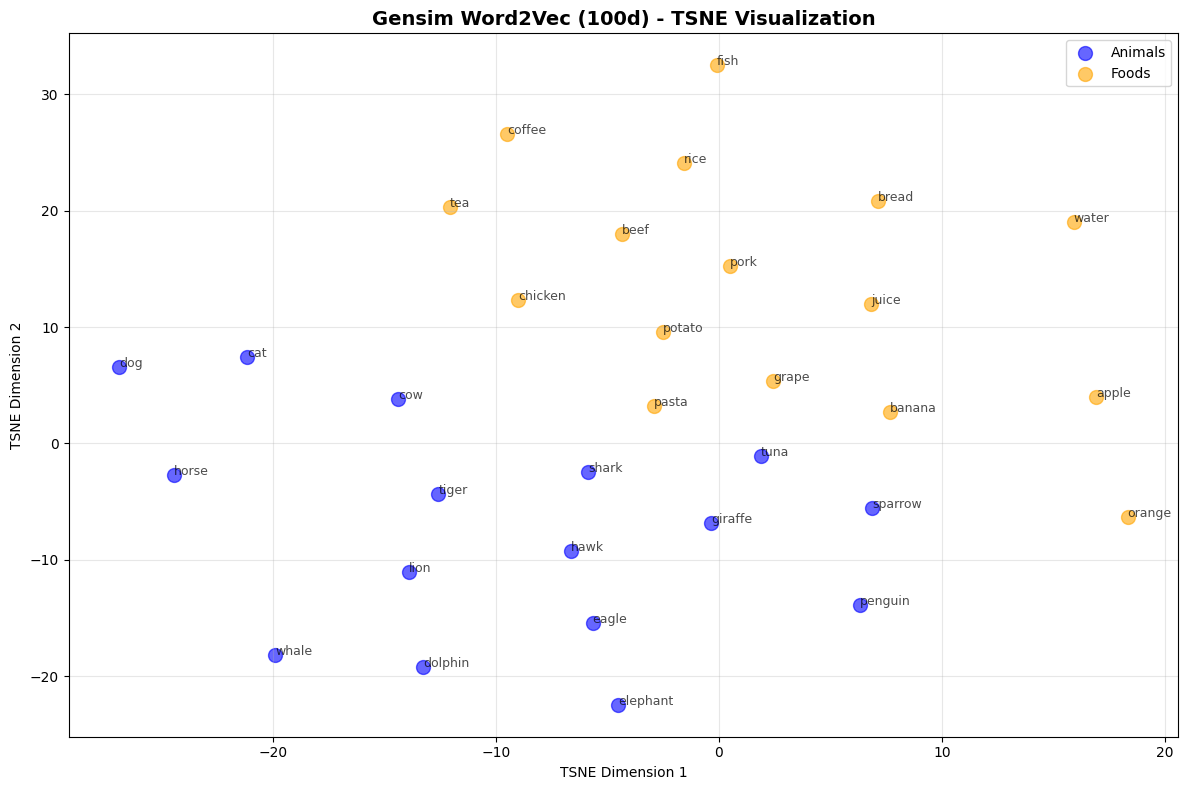

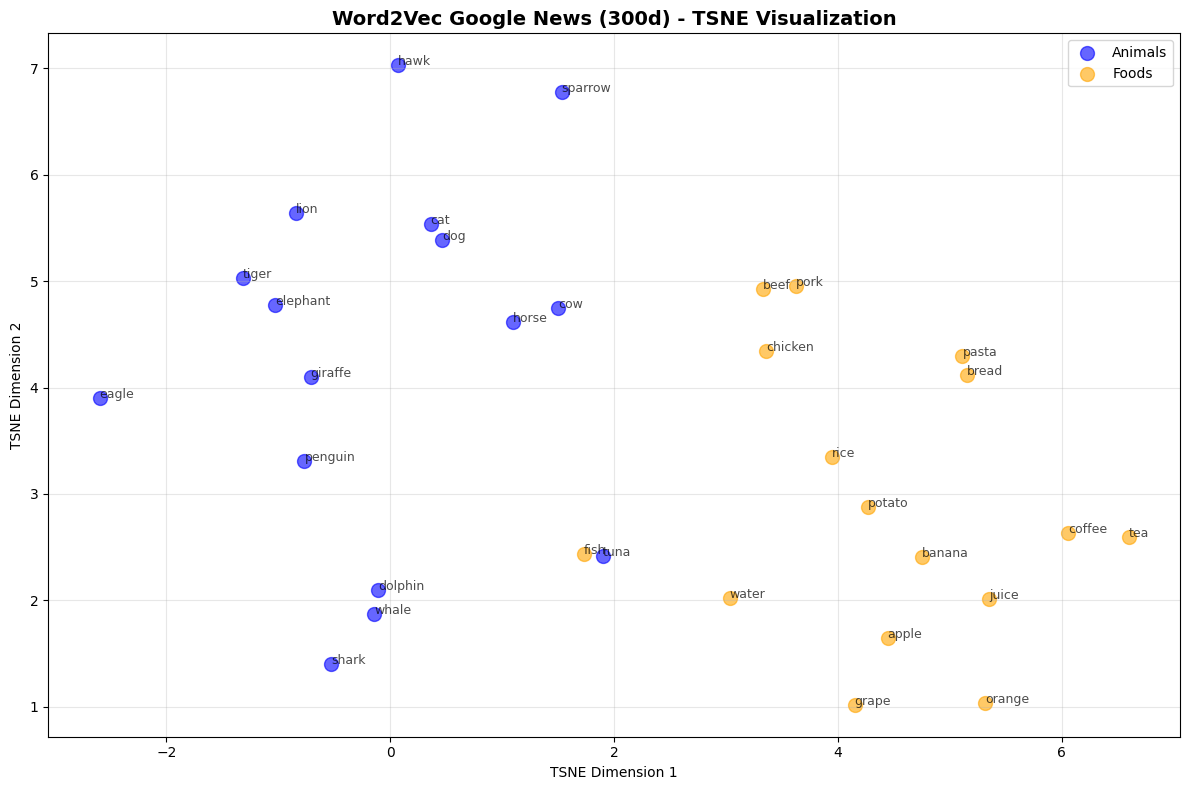

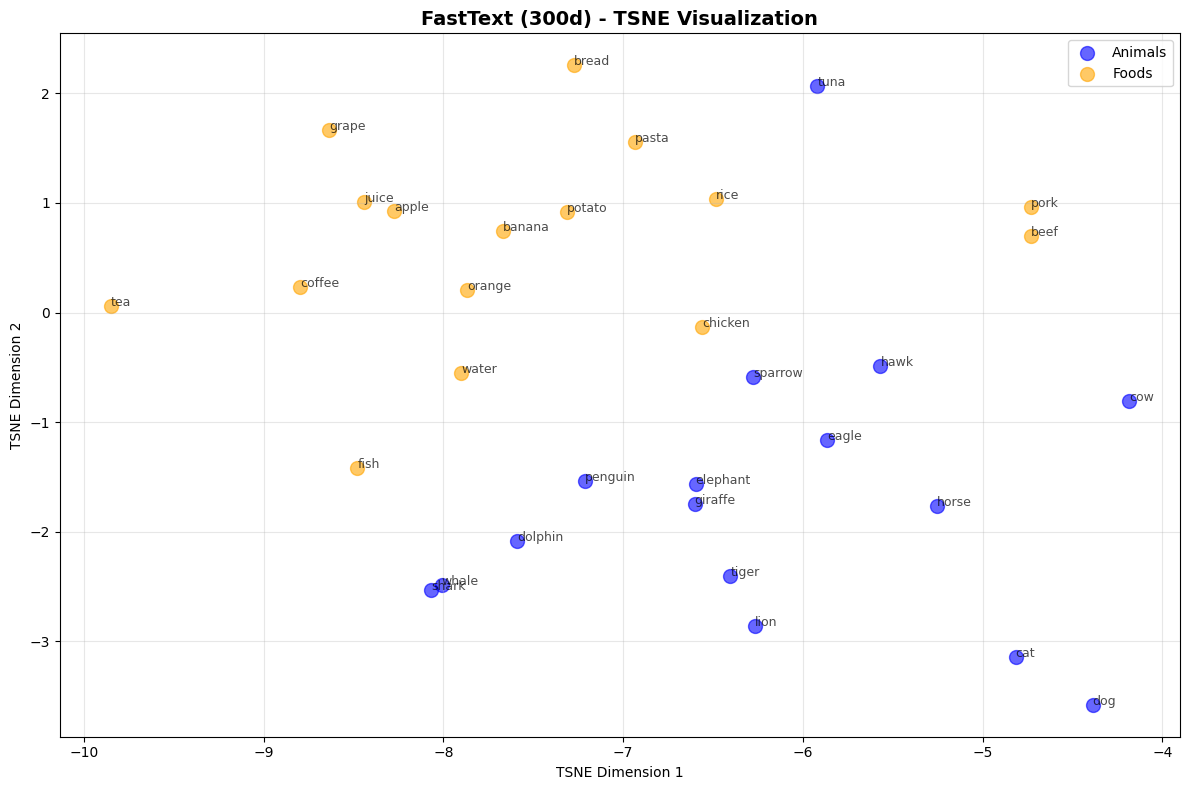

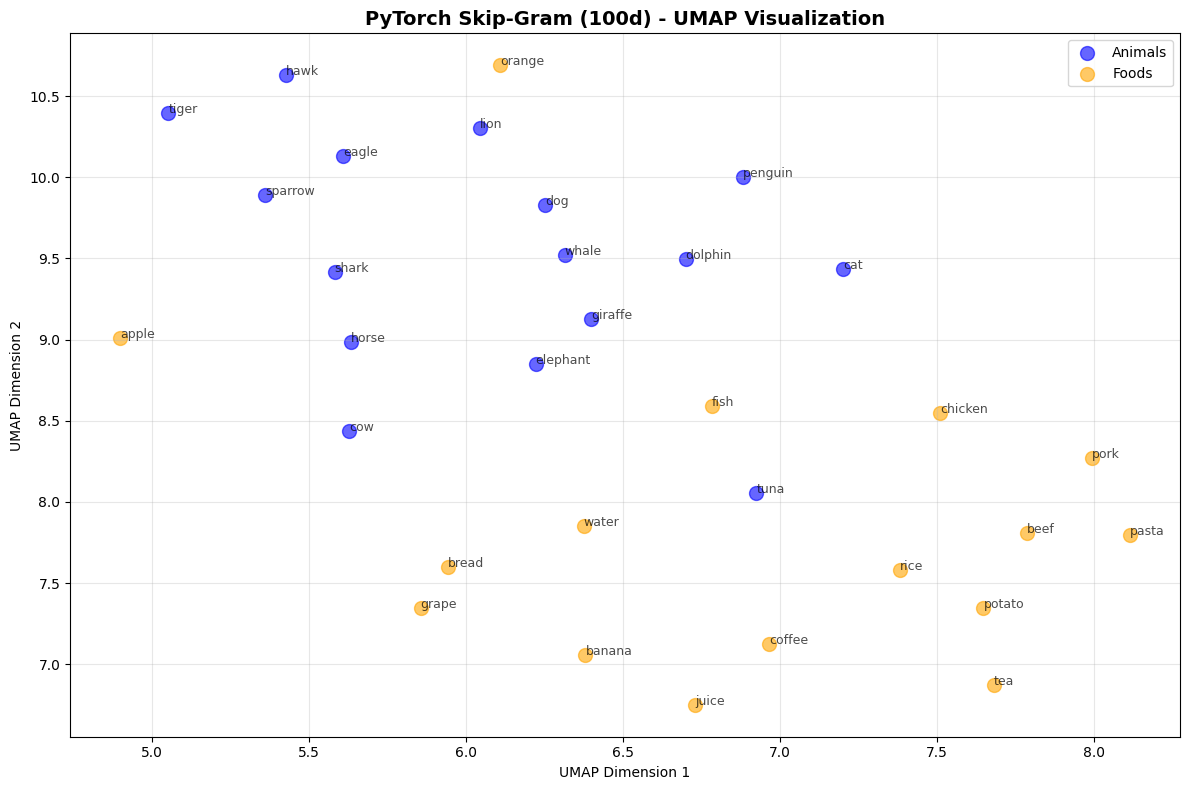

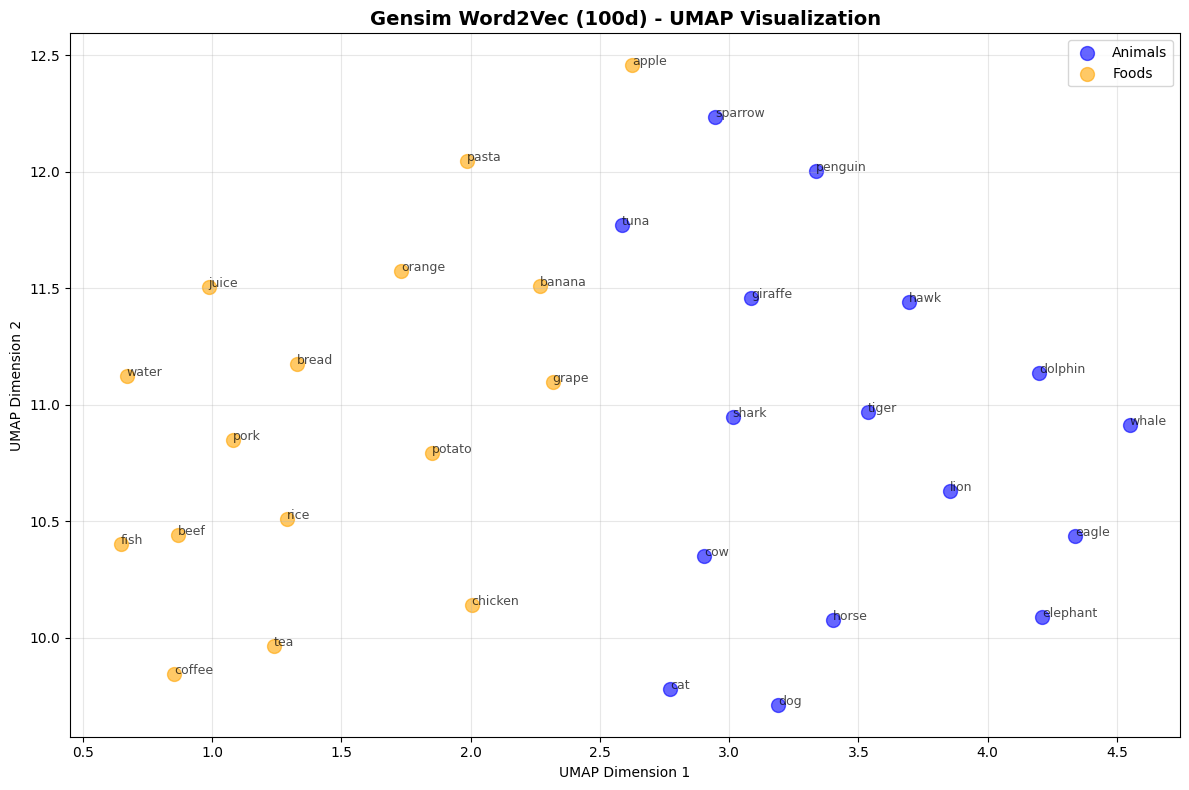

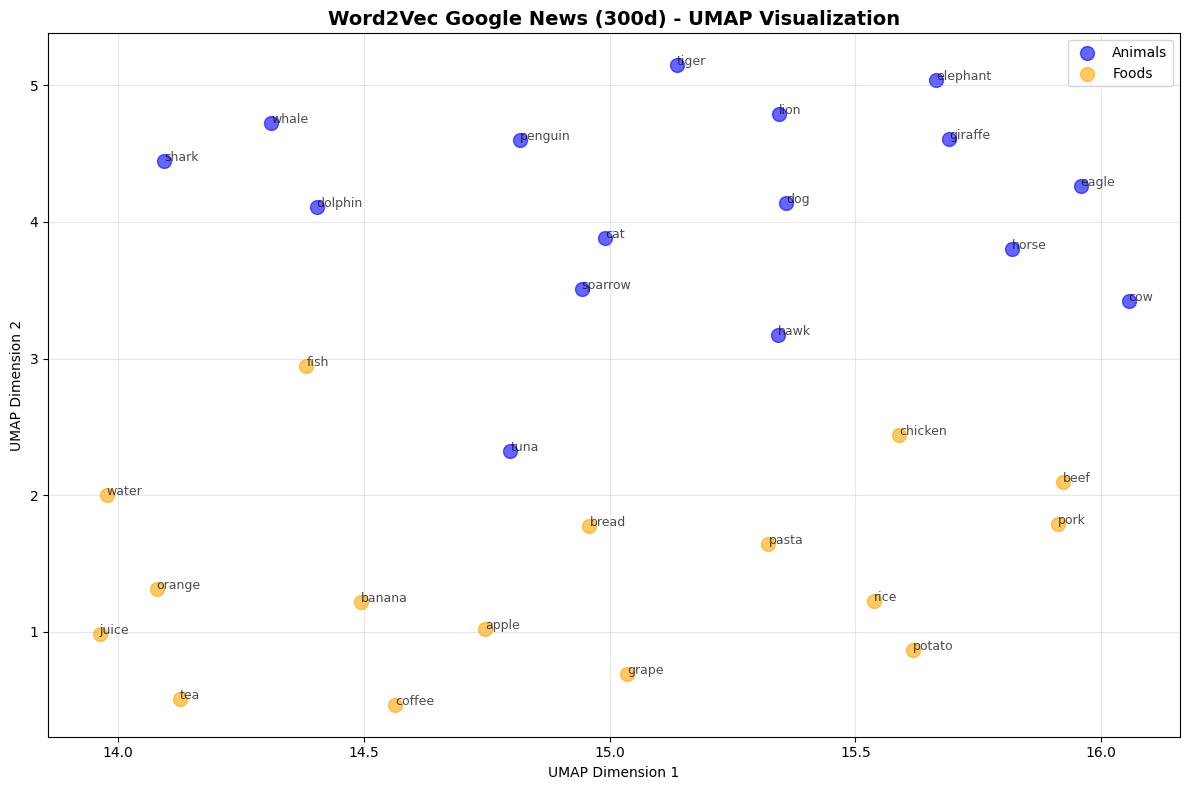

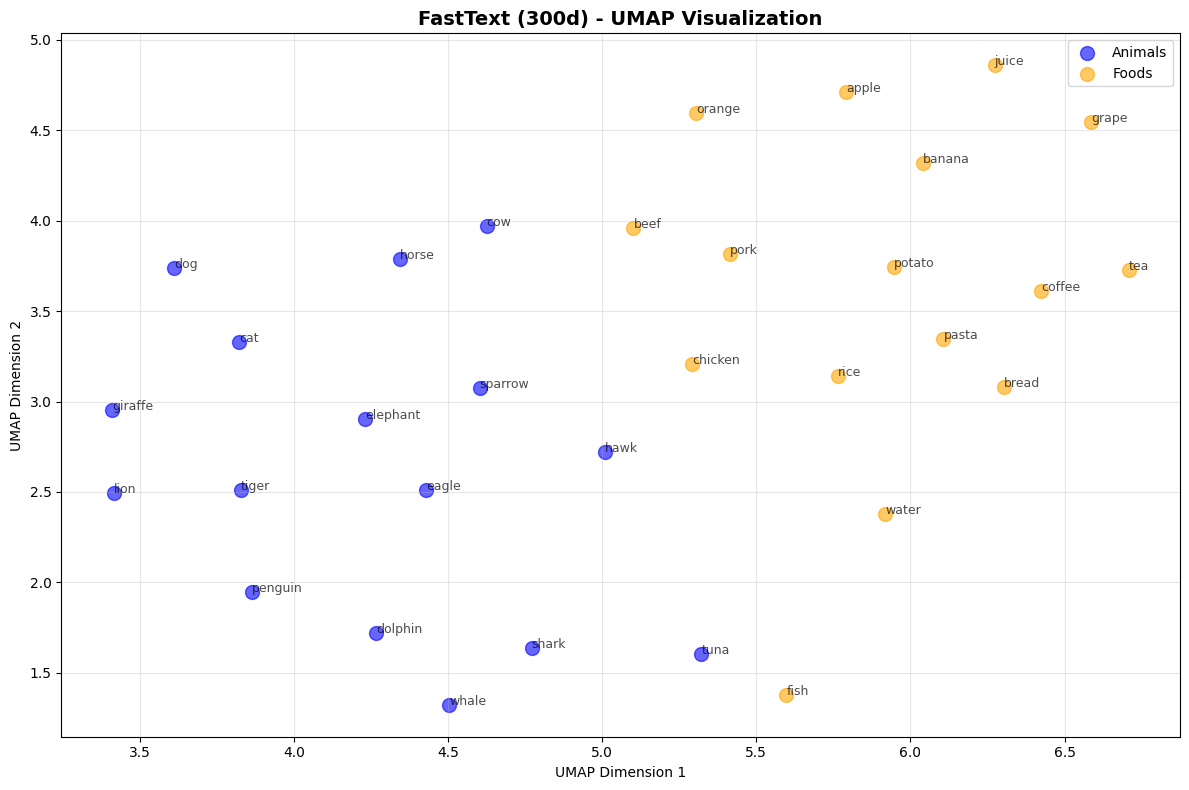

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Define word categories
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

# Helper function to get embeddings for a list of words
def get_embeddings_for_words(words, embeddings, word2idx):
    """
    Extract embeddings for a list of words.
    
    Args:
        words: list of words
        embeddings: embedding matrix
        word2idx: word to index mapping
    
    Returns:
        word_vectors: list of embeddings
    """
    word_vectors = []
    
    for word in words:
        idx = word2idx[word]
        word_vectors.append(embeddings[idx])
    
    return np.array(word_vectors)

# For pretrained models
def get_embeddings_for_words_pretrained(words, model):
    """
    Extract embeddings from pretrained Gensim model.
    """
    word_vectors = []
    
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    
    return np.array(word_vectors)

# Visualization function
def visualize_embeddings(embeddings, word2idx, model_name, method='tsne', is_pretrained=False, model=None):
    """
    Visualize embeddings using t-SNE or UMAP.
    
    Args:
        embeddings: embedding matrix or None if pretrained
        word2idx: word to index mapping or None if pretrained
        model_name: name for plot title
        method: 'tsne' or 'umap'
        is_pretrained: whether using pretrained model
        model: pretrained model (if applicable)
    """
    # Get embeddings for both categories
    if is_pretrained:
        animal_vecs = get_embeddings_for_words_pretrained(animals, model)
        food_vecs = get_embeddings_for_words_pretrained(foods, model)
    else:
        animal_vecs = get_embeddings_for_words(animals, embeddings, word2idx)
        food_vecs = get_embeddings_for_words(foods, embeddings, word2idx)
    
    # Combine all embeddings
    all_vecs = np.vstack([animal_vecs, food_vecs])
    all_words = animals + foods
    
    # Create labels (0 for animals, 1 for foods)
    labels = [0] * len(animals) + [1] * len(foods)
    
    # Apply dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=15, max_iter=1000)
        coords = reducer.fit_transform(all_vecs)
    else:  # umap
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        coords = reducer.fit_transform(all_vecs)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Plot animals (blue)
    animal_coords = coords[:len(animals)]
    plt.scatter(animal_coords[:, 0], animal_coords[:, 1], 
                c='blue', label='Animals', s=100, alpha=0.6)
    
    # Plot foods (orange)
    food_coords = coords[len(animals):]
    plt.scatter(food_coords[:, 0], food_coords[:, 1], 
                c='orange', label='Foods', s=100, alpha=0.6)
    
    # Add word labels
    for i, word in enumerate(all_words):
        plt.annotate(word, (coords[i, 0], coords[i, 1]), 
                    fontsize=9, alpha=0.7)
    
    plt.title(f'{model_name} - {method.upper()} Visualization', fontsize=14, fontweight='bold')
    plt.xlabel(f'{method.upper()} Dimension 1')
    plt.ylabel(f'{method.upper()} Dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    

# Generate all visualizations

# t-SNE visualizations
visualize_embeddings(pytorch_embeddings, pytorch_word2idx, 
                    "PyTorch Skip-Gram (100d)", method='tsne')

visualize_embeddings(gensim_embeddings, gensim_word2idx, 
                    "Gensim Word2Vec (100d)", method='tsne')

visualize_embeddings(None, None, 
                    "Word2Vec Google News (300d)", method='tsne',
                    is_pretrained=True, model=googlenews_model)

visualize_embeddings(None, None, 
                    "FastText (300d)", method='tsne',
                    is_pretrained=True, model=fasttext_model)

# UMAP visualizations
visualize_embeddings(pytorch_embeddings, pytorch_word2idx, 
                    "PyTorch Skip-Gram (100d)", method='umap')

visualize_embeddings(gensim_embeddings, gensim_word2idx, 
                    "Gensim Word2Vec (100d)", method='umap')

visualize_embeddings(None, None, 
                    "Word2Vec Google News (300d)", method='umap',
                    is_pretrained=True, model=googlenews_model)

visualize_embeddings(None, None, 
                    "FastText (300d)", method='umap',
                    is_pretrained=True, model=fasttext_model)

### Short Answer Questions

1. Which embeddings performed best at capturing sentence meaning?  
**Word2Vec Google News (300d)** performed best. It correctly identified the synonym-heavy sentence "The feline was resting on the rug" with 0.78 similarity. FastText scored higher (0.92) but showed poor discrimination with all sentences ranging 0.61-0.92. Our PyTorch and Gensim models (100d) performed reasonably at 0.60-0.72 for top matches but had lower similarity scores. Google News provided the best balance between accuracy and discrimination.

2. Were the pretrained embeddings significantly better than your own? Why or why not?  
Pretrained embeddings were better but not dramatically so. Google News and FastText respectively achieved 0.78 and 0.92 for the synonym sentence while our models scored 0.48-0.60, showing superior semantic understanding. However, both correctly identified the most similar sentence with comparable scores (0.69-0.72). Visualizations showed pretrained models had clearer separation between categories, but our models still formed meaningful clusters. \

3. What factors might explain the differences in performance?  
The key factors are training data scale (billions vs 17 million words), dimensionality (300d vs 100d), and domain diversity (varied news articles vs Wikipedia only). Pretrained models observed more word co-occurrences across diverse contexts, enabling richer semantic understanding. 

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>
I used Claude to check the validity of my code, especially the loss function (to match with the original paper).